# Image Enhancement

PIL.JpegImagePlugin.JpegImageFile

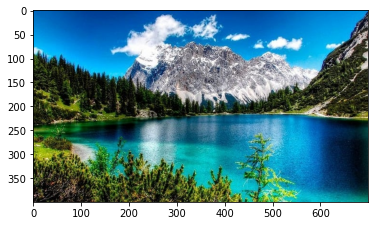

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img3 = Image.open('data/image.jpg')
plt.imshow(img3)
type(img3)

In [4]:
# Save the image
np.save('data/img.npy', img3)

#Load the image
img3 = np.load('data/img.npy')

Let's look at the distribution of pixel values in the image. Ideally, the image should have relatively even distribution of values, indicating good contrast and making it easier to extract analytical information.

An easy way to check this is to plot a histogram.

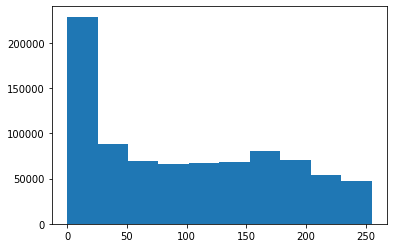

In [5]:
import matplotlib.pyplot as plt

# Plot a histogram - we need to use ravel to "flatten" the 3 dimensions
plt.hist(img3.ravel())
plt.show()

Another useful way to visualize the statistics of an image is as a cumulative distribution function (CDF) plot. Which shows the cumulative pixel intensity frequencies from 0 to 255.

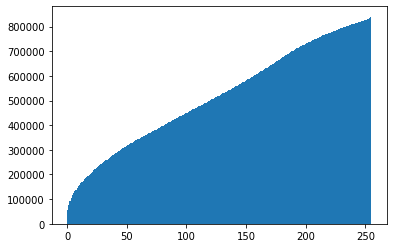

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(img3.ravel(), bins=255, cumulative=True)
plt.show()

The histogram and CDF for our image show pretty uneven distribution - there's a lot of contrast in the image. Ideally we should equalize the values in the images we want to analyse to try to make our images more consistent in terms of the shapes they contain irrespective of light levels.

Histogram equalization is often used to improve the statistics of images. In simple terms, the histogram equalization algorithm attempts to adjust the pixel values in the image to create a more uniform distribution. The code in the cell below uses the  **exposure.equalize_hist** method from the **skimage** package to equalize the image.  

c:\ProgramData\Anaconda3\envs\PhD\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


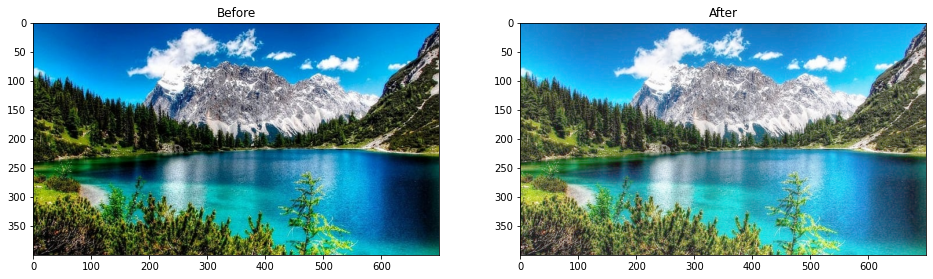

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure
%matplotlib inline

img3_eq = exposure.equalize_hist(img3)

# Display using matplotlib

# Create a figure
fig = plt.figure(figsize=(16, 8))

# Subplot for original image
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(img3)
a.set_title('Before')

# Subplot for processed image
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(img3_eq)
a.set_title('After')

plt.show()

As with most image operations, there's more than one way to do this. For example, you could also use the **PIL.ImgOps.equalize** method:

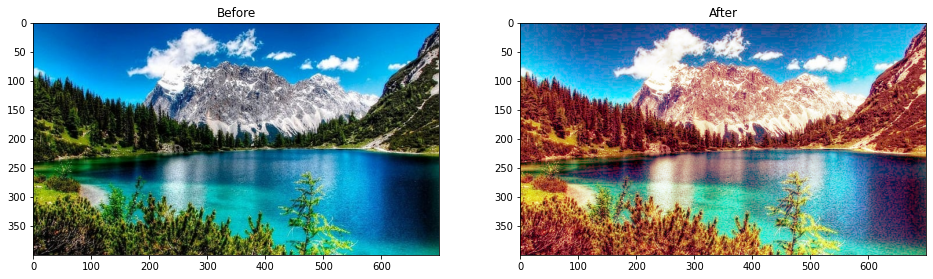

In [8]:
from PIL import Image, ImageOps
%matplotlib inline

# Equalize the image - but we need to convert the numpy array back to the PIL image format
img3PIL_eq = ImageOps.equalize(Image.fromarray(img3))

# Display using matplotlib

# Create a figure
fig = plt.figure(figsize=(16, 8))

# Subplot for original image
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(img3)
a.set_title('Before')

# Subplot for processed image
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(img3PIL_eq)
a.set_title('After')

plt.show()

Now let's see what that's done to the histogram and CDF plots:

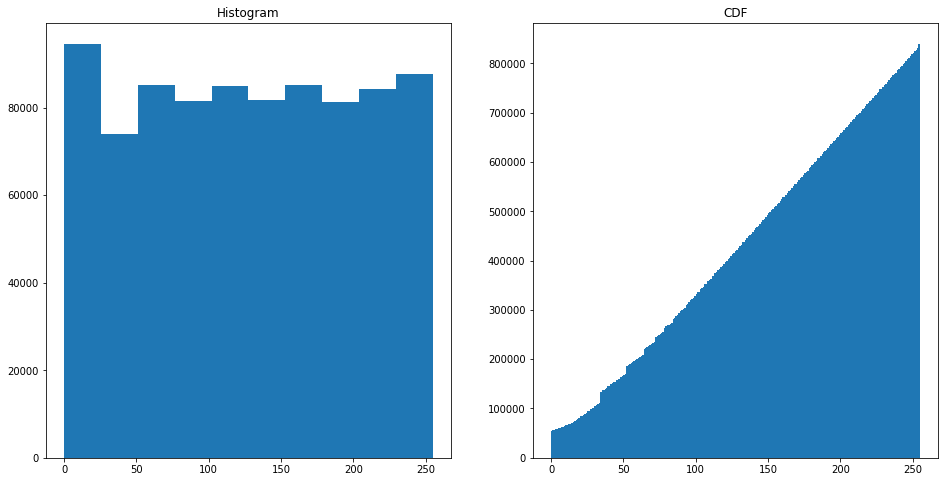

In [9]:
# Display histograms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
%matplotlib inline

img3_eq = np.array(img3PIL_eq)

# Create a figure
fig = plt.figure(figsize=(16, 8))

# Subplot for original image
a=fig.add_subplot(1,2,1)
imgplot = plt.hist(img3_eq.ravel())
a.set_title('Histogram')

# Subplot for processed image
a=fig.add_subplot(1,2,2)
imgplot = plt.hist(img3_eq.ravel(), bins=255, cumulative=True)
a.set_title('CDF')

plt.show()

The pixel intensities are more evenly distributed in the equalized image. In particular, the cumulative density shows a straight diagonal cumulation; which is a good sign that the pixel intensity values have been equalized.

## Denoising with Filters

Often images need to be cleaned up to remove "salt and pepper" noise.

### Add Some Random Noise
Let's add some random noise to our image - such as you might see in a photograph taken in low light or at a low resolution.

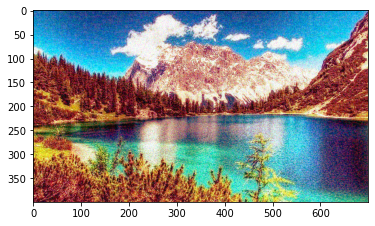

In [10]:
import skimage
%matplotlib inline

img3_n = skimage.util.random_noise(img3_eq)
plt.imshow(img3_n)

### Using a Gaussian Filter
A Gaussian filter applies a weighted average (mean) value for pixels based on the pixels that surround them.

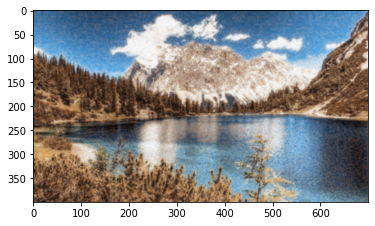

In [11]:
from scipy.ndimage.filters import gaussian_filter as gauss
%matplotlib inline

img3_gauss = gauss(img3_n, sigma=1)   
plt.imshow(img3_gauss)

### Using a Median Filter
The Gaussian filter results in a blurred image, which may actually be better for feature extraction as it makes it easier to find contrasting areas. If it's too blurred, we could try a median filter, which as the name suggests applies the median value to pixels based on the pixels around them.

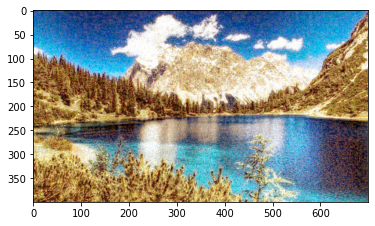

In [12]:
from scipy.ndimage.filters import median_filter as med
%matplotlib inline

img3_med = med(img3_n, size=2)
plt.imshow(img3_med)

### Extract Features
Now that we've done some initial processing of the image to improve its statistics for analysis, we can start to extract features from it.
#### Sobel Edge Detection
As a first step in extracting features, you will apply the Sobel edge detection algorithm. This finds regions of the image with large gradient values in multiple directions. Regions with high omnidirectional gradient are likely to be edges or transitions in the pixel values. 

The code in the cell below applies the Sobel algorithm to the median filtered image, using these steps:

1. Convert the color image to grayscale for the gradient calculation since it is two dimensional.
2. Compute the gradient in the x and y (horizontal and vertical) directions. 
3. Compute the magnitude of the gradient.
4. Normalize the gradient values. 


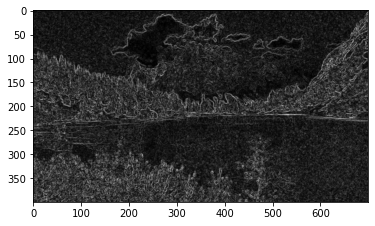

In [13]:
def edge_sobel(image):
    from scipy import ndimage
    import skimage.color as sc
    import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

img3_edge = edge_sobel(img3_med)
plt.imshow(img3_edge, cmap="gray")

Now let's try with the more blurred gaussian filtered image.

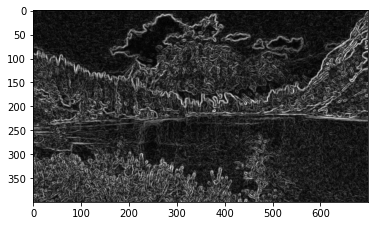

In [14]:
img3_edge = edge_sobel(img3_gauss)
plt.imshow(img3_edge, cmap="gray")